# Part(2): Forecasting

В этом выпуске: попробуем использовать признаки для решения задачи прогнозирования на примере tsfresh


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (23, 9)


HORIZON = 365

## 1. Загрузка данных

Будем работать с данным сореванования, которое мы решаем в домашке

In [2]:
segment = "Italy-PremiumDevices-ShadowX"
df = pd.read_parquet("data/train.parquet")
df_tsfresh = df[df["segment"] == segment]
df_tsfresh.head()

,segment,timestamp,target,country,store,product
43,Italy-PremiumDevices-ShadowX,2010-01-01,429.0,Italy,Premium Devices,ShadowX
131,Italy-PremiumDevices-ShadowX,2010-01-02,443.0,Italy,Premium Devices,ShadowX
219,Italy-PremiumDevices-ShadowX,2010-01-03,466.0,Italy,Premium Devices,ShadowX
307,Italy-PremiumDevices-ShadowX,2010-01-04,350.0,Italy,Premium Devices,ShadowX
395,Italy-PremiumDevices-ShadowX,2010-01-05,378.0,Italy,Premium Devices,ShadowX


<Axes: xlabel='timestamp'>

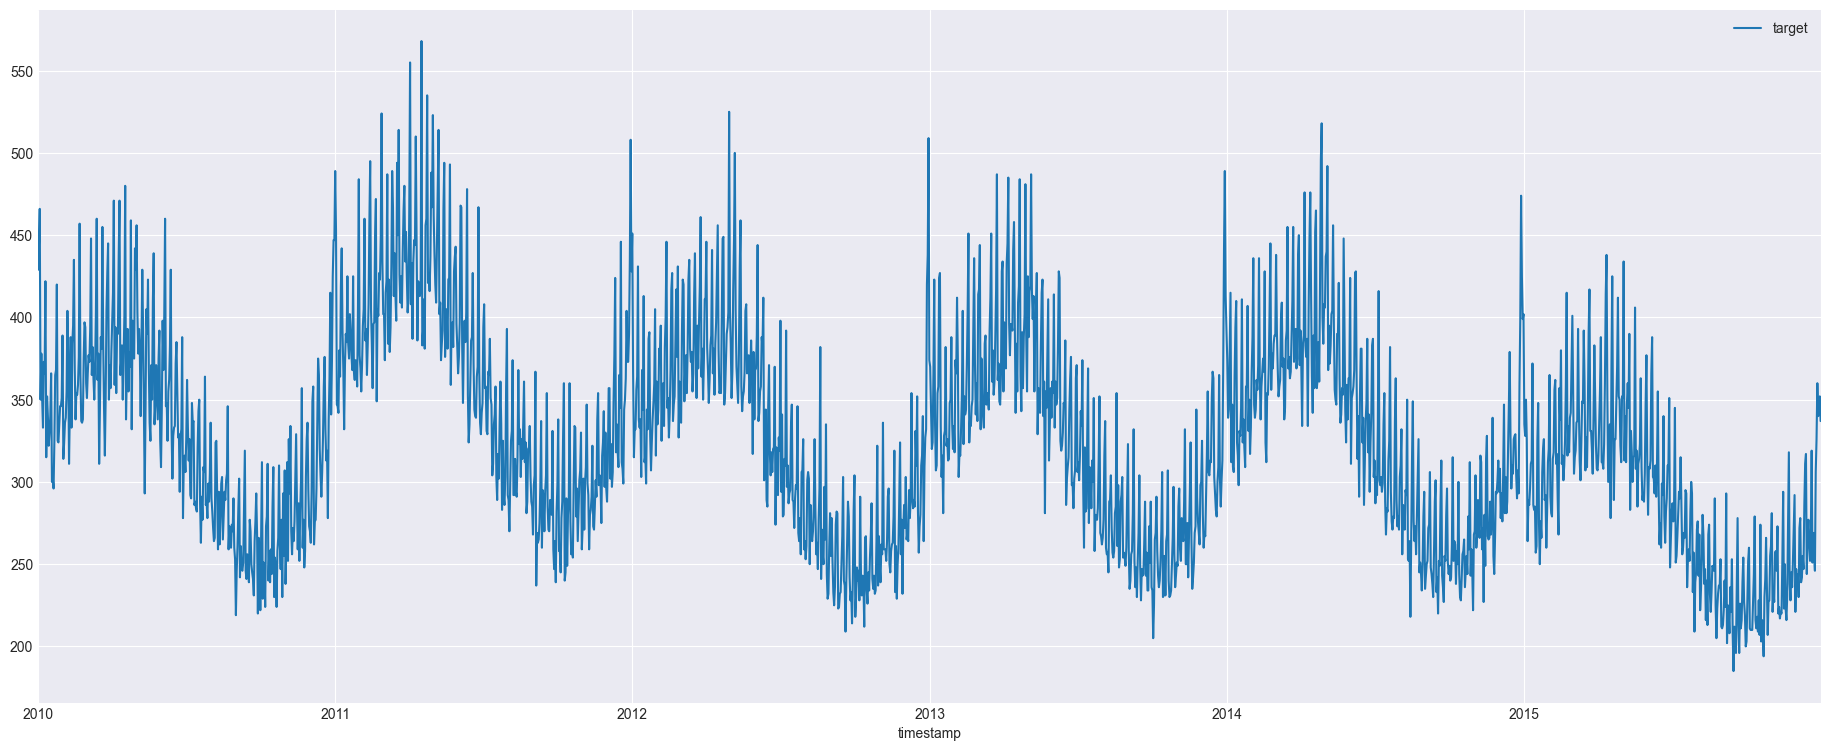

In [3]:
df_tsfresh.set_index("timestamp").plot(ax=plt.gca())

## 2. Подготовка контекста для выделения признаков

Для начала необходимо подготовить данные, для подсчета статистик в окнах

В случае задачи классификации мы считали признаки для ряда в целом, в данном случаем нам нужны признаки для каждой точки

In [4]:
from tsfresh.utilities.dataframe_functions import roll_time_series

In [5]:
df_rolled = roll_time_series(
    df_tsfresh,
    column_id="segment",
    column_sort="timestamp",
    rolling_direction=1,  # Насколько двигаем окно
    min_timeshift=7,
    max_timeshift=21,  # Размер окна
    n_jobs=1,
)

Rolling: 100%|██████████████████████████████| 2191/2191 [00:01<00:00, 1782.32it/s]


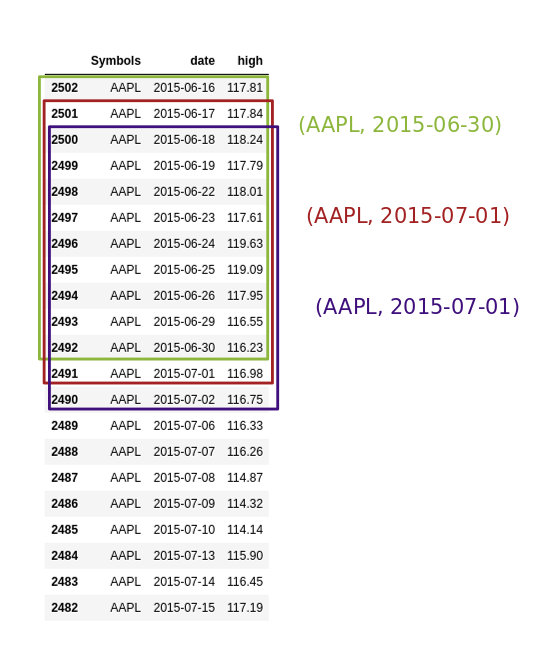

In [6]:
df_rolled.head()

,segment,timestamp,target,country,store,product,id
0,Italy-PremiumDevices-ShadowX,2010-01-01,429.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
1,Italy-PremiumDevices-ShadowX,2010-01-02,443.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
2,Italy-PremiumDevices-ShadowX,2010-01-03,466.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
3,Italy-PremiumDevices-ShadowX,2010-01-04,350.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
4,Italy-PremiumDevices-ShadowX,2010-01-05,378.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."


In [7]:
df_rolled[
    df_rolled["id"] == (segment, pd.to_datetime("2010-01-08"))
]  # Для каждого ряда/точки получаем окно, в котором будем считать признаки

,segment,timestamp,target,country,store,product,id
0,Italy-PremiumDevices-ShadowX,2010-01-01,429.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
1,Italy-PremiumDevices-ShadowX,2010-01-02,443.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
2,Italy-PremiumDevices-ShadowX,2010-01-03,466.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
3,Italy-PremiumDevices-ShadowX,2010-01-04,350.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
4,Italy-PremiumDevices-ShadowX,2010-01-05,378.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
5,Italy-PremiumDevices-ShadowX,2010-01-06,350.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
6,Italy-PremiumDevices-ShadowX,2010-01-07,333.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."
7,Italy-PremiumDevices-ShadowX,2010-01-08,373.0,Italy,Premium Devices,ShadowX,"(Italy-PremiumDevices-ShadowX, 2010-01-08 00:0..."


## 3. Выделение признаков в окнах

Попробуем несколько наборов признаков и посмотрим есть ли прирост в качестве

In [8]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

In [9]:
X = extract_features(
    df_rolled.drop(columns=["segment"]),
    default_fc_parameters=MinimalFCParameters(),
    column_id="id",
    column_sort="timestamp",
    column_value="target",
    impute_function=None,
    show_warnings=False,
    n_jobs=1,
)

Feature Extraction: 100%|███████████████████| 2184/2184 [00:00<00:00, 6735.15it/s]


In [10]:
X_eff = extract_features(
    df_rolled.drop(columns=["segment"]),
    default_fc_parameters=EfficientFCParameters(),
    column_id="id",
    column_sort="timestamp",
    column_value="target",
    impute_function=impute,
    show_warnings=False,
    n_jobs=1,
)

Feature Extraction: 100%|█████████████████████| 2184/2184 [01:03<00:00, 34.24it/s]


In [11]:
X.shape, X_eff.shape

((2184, 10), (2184, 777))

In [12]:
X.head()

target__sum_values  target__median  \
Italy-PremiumDevices-ShadowX 2010-01-08              3122.0           375.5   
                             2010-01-09              3488.0           373.0   
                             2010-01-10              3910.0           375.5   
                             2010-01-11              4225.0           373.0   
                             2010-01-12              4577.0           369.5   

                                         target__mean  target__length  \
Italy-PremiumDevices-ShadowX 2010-01-08    390.250000             8.0   
                             2010-01-09    387.555556             9.0   
                             2010-01-10    391.000000            10.0   
                             2010-01-11    384.090909            11.0   
                             2010-01-12    381.416667            12.0   

                                         target__standard_deviation  \
Italy-PremiumDevices-ShadowX 2010-01-08                   46.080771   
                             2010-01-09                   44.108732   
                             2010-01-10                   43.102204   
                             2010-01-11                   46.543146   
                             2010-01-12                   45.435776   

                                         target__variance  \
Italy-PremiumDevices-ShadowX 2010-01-08       2123.437500   
                             2010-01-09       1945.580247   
                             2010-01-10       1857.800000   
                             2010-01-11       2166.264463   
                             2010-01-12       2064.409722   

                                         target__root_mean_square  \
Italy-PremiumDevices-ShadowX 2010-01-08                392.961194   
                             2010-01-09                390.057546   
                             2010-01-10                393.368529   
                             2010-01-11                386.900621   
                             2010-01-12                384.113373   

                                         target__maximum  \
Italy-PremiumDevices-ShadowX 2010-01-08            466.0   
                             2010-01-09            466.0   
                             2010-01-10            466.0   
                             2010-01-11            466.0   
                             2010-01-12            466.0   

                                         target__absolute_maximum  \
Italy-PremiumDevices-ShadowX 2010-01-08                     466.0   
                             2010-01-09                     466.0   
                             2010-01-10                     466.0   
                             2010-01-11                     466.0   
                             2010-01-12                     466.0   

                                         target__minimum  
Italy-PremiumDevices-ShadowX 2010-01-08            333.0  
                             2010-01-09            333.0  
                             2010-01-10            333.0  
                             2010-01-11            315.0  
                             2010-01-12            315.0

In [13]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"

X_eff = X_eff.set_index(X_eff.index.map(lambda x: x[1]), drop=True)
X_eff.index.name = "last_date"

X.head()

,target__sum_values,target__median,target__mean,target__length,target__standard_deviation,target__variance,target__root_mean_square,target__maximum,target__absolute_maximum,target__minimum
last_date,,,,,,,,,,
2010-01-08,3122.0,375.5,390.250000,8.0,46.080771,2123.437500,392.961194,466.0,466.0,333.0
2010-01-09,3488.0,373.0,387.555556,9.0,44.108732,1945.580247,390.057546,466.0,466.0,333.0
2010-01-10,3910.0,375.5,391.000000,10.0,43.102204,1857.800000,393.368529,466.0,466.0,333.0
2010-01-11,4225.0,373.0,384.090909,11.0,46.543146,2166.264463,386.900621,466.0,466.0,315.0
2010-01-12,4577.0,369.5,381.416667,12.0,45.435776,2064.409722,384.113373,466.0,466.0,315.0


In [14]:
y = df_tsfresh.set_index("timestamp")["target"]
y = y[y.index.isin(X.index)]

## 4. Подготовка датасета

Теперь нужно подготовить данные для обучения и валидации. 

В качестве валидации отрежем последний фолд размера HORIZON

В качествае признаков для точки t будем использовать данные признки точки t - Horizon (тут нужно порисовать)

In [15]:
X_train = X.iloc[: -2 * HORIZON]
X_test = X.iloc[-2 * HORIZON : -HORIZON]

X_train_eff = X_eff.iloc[: -2 * HORIZON]
X_test_eff = X_eff.iloc[-2 * HORIZON : -HORIZON]

y_train = y.iloc[:-HORIZON].shift(-HORIZON).dropna()
y_test = y.iloc[-HORIZON:]

In [16]:
assert (X_train.index == y_train.index).all

In [17]:
assert len(X_test) == len(y_test)

## 5. Отбор признаков

In [18]:
from tsfresh import select_features

In [19]:
X_train_selected = select_features(X_train, y_train, ml_task="regression", n_jobs=1)

In [20]:
X_train_selected.shape

(1454, 10)

In [21]:
X_train_selected_eff = select_features(X_train_eff, y_train, ml_task="regression", n_jobs=1)

In [22]:
X_train_selected_eff.shape

(1454, 237)

## 6. Построение модели

In [23]:
from catboost import CatBoostRegressor

In [24]:
model = CatBoostRegressor()
model.fit(X_train_selected, y_train)

model_eff = CatBoostRegressor()
model_eff.fit(X_train_selected_eff, y_train)

Learning rate set to 0.043437
0:	learn: 63.3419290	total: 58.9ms	remaining: 58.9s
1:	learn: 61.8871828	total: 59.5ms	remaining: 29.7s
2:	learn: 60.5158681	total: 60ms	remaining: 19.9s
3:	learn: 59.2164804	total: 60.4ms	remaining: 15s
4:	learn: 58.0382335	total: 60.9ms	remaining: 12.1s
5:	learn: 56.9064142	total: 61.4ms	remaining: 10.2s
6:	learn: 55.8311734	total: 61.9ms	remaining: 8.78s
7:	learn: 54.8343215	total: 62.3ms	remaining: 7.73s
8:	learn: 53.8855760	total: 62.9ms	remaining: 6.92s
9:	learn: 53.0104594	total: 63.4ms	remaining: 6.27s
10:	learn: 52.1990818	total: 63.8ms	remaining: 5.74s
11:	learn: 51.4421854	total: 64.3ms	remaining: 5.29s
12:	learn: 50.7094117	total: 64.8ms	remaining: 4.92s
13:	learn: 50.0653715	total: 65.3ms	remaining: 4.6s
14:	learn: 49.4524313	total: 65.8ms	remaining: 4.32s
15:	learn: 48.8752807	total: 66.3ms	remaining: 4.08s
16:	learn: 48.3389874	total: 66.8ms	remaining: 3.86s
17:	learn: 47.8327833	total: 67.2ms	remaining: 3.67s
18:	learn: 47.3842681	total: 67

In [25]:
X_test_selected = X_test[X_train_selected.columns]
X_test_selected_eff = X_test_eff[X_train_selected_eff.columns]

y_pred = pd.Series(model.predict(X_test_selected), index=y_test.index)
y_pred_eff = pd.Series(model_eff.predict(X_test_selected_eff), index=y_test.index)

<Axes: xlabel='timestamp'>

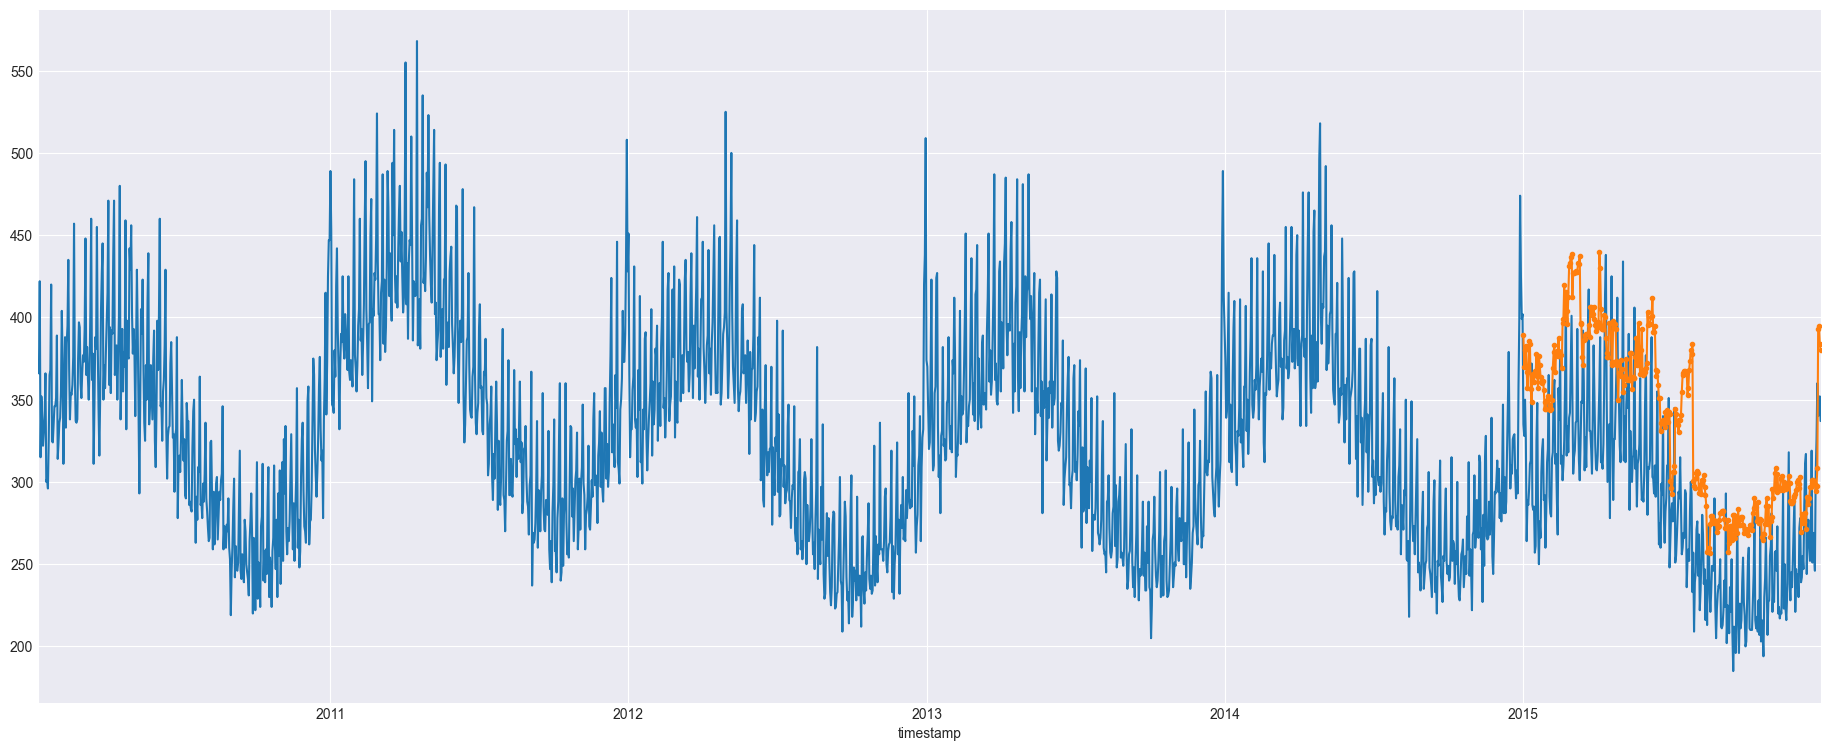

In [26]:
y.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")

<Axes: xlabel='timestamp'>

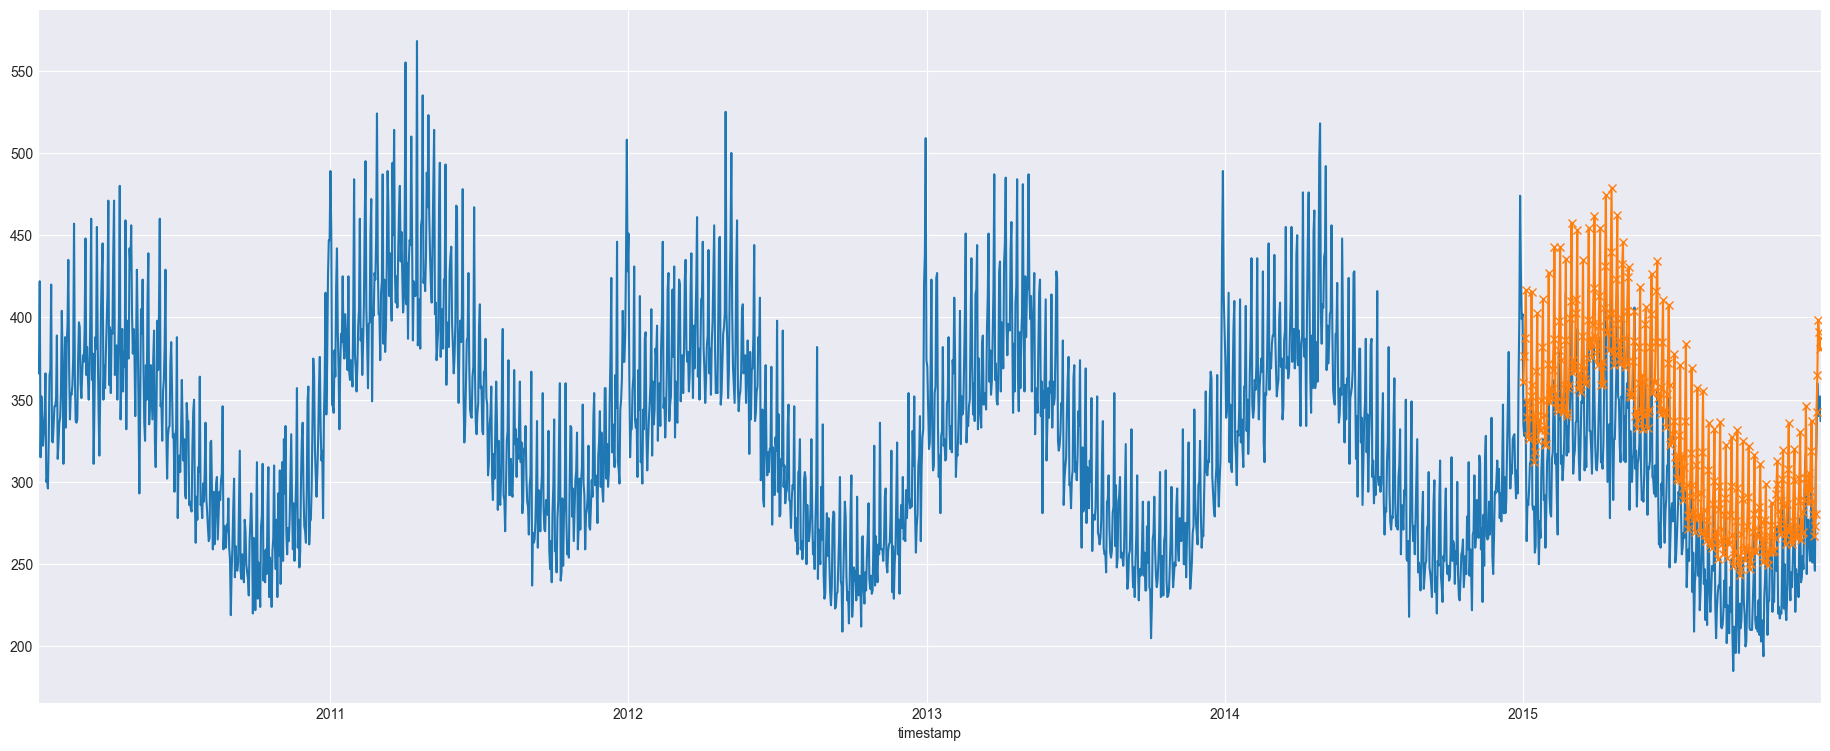

In [27]:
y.plot(ax=plt.gca())
y_pred_eff.plot(ax=plt.gca(), legend=None, marker="x")

Метрики получились в целом не такие уж плохие

In [28]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [29]:
mean_absolute_error(y_pred, y_test), mean_absolute_percentage_error(y_pred=y_pred, y_true=y_test)

(55.15055672925385, 0.20362917041840092)

In [30]:
mean_absolute_error(y_pred_eff, y_test), mean_absolute_percentage_error(y_pred=y_pred_eff, y_true=y_test)

(46.70929732993921, 0.16952391723362817)

# Отбор рядов по разным характеристикам
На лекции обсуждали что некоторые признаки можно использовать для отбора рядов, с какими-то особенностями:
- Трендовость
- Симметричность
- Предсказуемость


Попробуем проделать такое упражнение на датасете M4

## 1. Загрузка данных

In [31]:
from etna.datasets.internal_datasets import list_datasets, load_dataset
import numpy as np

list_datasets()

['ETTh1',
 'ETTh2',
 'ETTm1',
 'ETTm2',
 'IHEPC_T',
 'australian_wine_sales_monthly',
 'electricity_15T',
 'm3_monthly',
 'm3_other',
 'm3_quarterly',
 'm3_yearly',
 'm4_daily',
 'm4_hourly',
 'm4_monthly',
 'm4_quarterly',
 'm4_weekly',
 'm4_yearly',
 'tourism_monthly',
 'tourism_quarterly',
 'tourism_yearly',
 'traffic_2008_10T',
 'traffic_2008_hourly',
 'traffic_2015_hourly',
 'weather_10T']

In [32]:
ts = load_dataset("m4_daily")

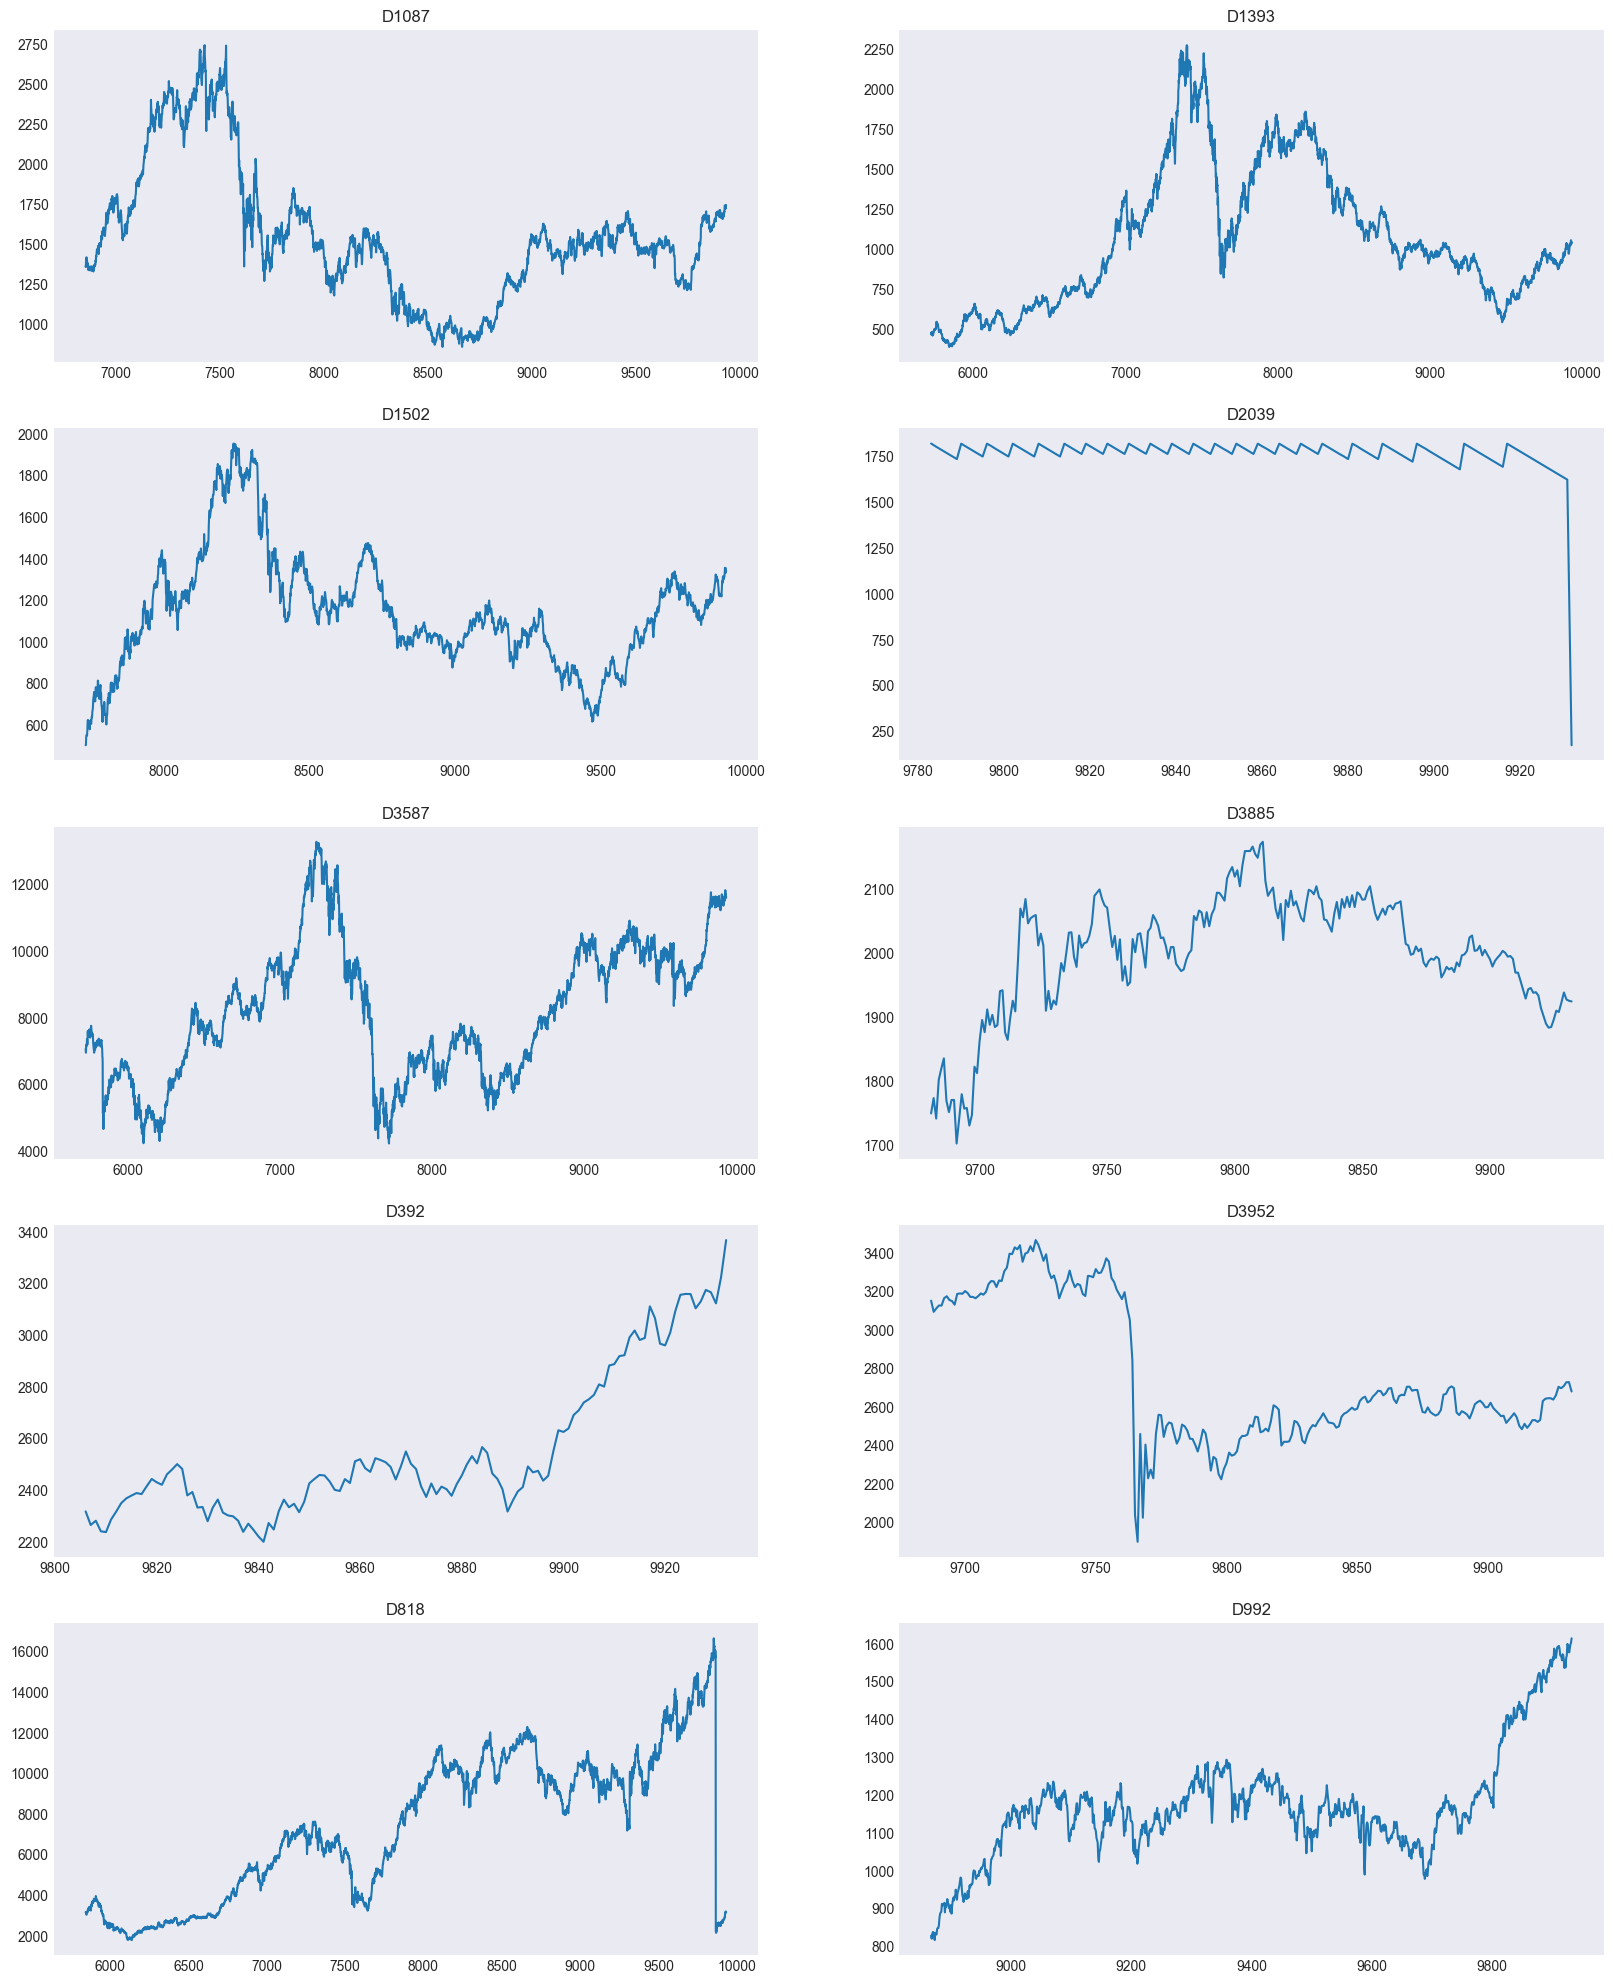

In [33]:
ts.plot()

In [34]:
df_dataset = pd.concat(
    [
        pd.DataFrame({"id": segment, "time": ts[:, segment, "target"].index, "value": ts[:, segment, "target"].values})
        for segment in ts.segments
    ],
    axis=0,
)

In [35]:
df_dataset.head()

,id,time,value
0,D1,8913,1017.1
1,D1,8914,1019.3
2,D1,8915,1017.0
3,D1,8916,1019.2
4,D1,8917,1018.7


## 2. Выделение признаков

In [36]:
dataset_features = extract_features(
    df_dataset,
    default_fc_parameters={
        "agg_linear_trend": [{"attr": "slope", "chunk_len": 30, "f_agg": "mean"}],  # Трендовость
        "linear_trend": [{"attr": "slope"}],  # Трендовость
        "c3": [{"lag": 1}],  # Предсказуемость
        "cid_ce": [{"normalize": True}],  # Предсказуемость
        "lempel_ziv_complexity": [{"bins": 10}],  # Предсказуемость
        "permutation_entropy": [{"tau": 3, "dimension": 7}],  # Предсказуемость
        "symmetry_looking": [{"r": 0.5}],  # Симметричность
        "time_reversal_asymmetry_statistic": [{"lag": 7}],  # Симметричность
        "variation_coefficient": None,  # Предсказуемость
    },
    column_id="id",
    column_sort="time",
    column_value="value",
    impute_function=None,
    show_warnings=False,
    n_jobs=1,
)

Feature Extraction: 100%|████████████████████| 4227/4227 [00:15<00:00, 264.42it/s]


## 1. Трендовость

In [37]:
dataset_features.sort_values('value__linear_trend__attr_"slope"')

,"value__agg_linear_trend__attr_""slope""__chunk_len_30__f_agg_""mean""","value__linear_trend__attr_""slope""",value__c3__lag_1,value__cid_ce__normalize_True,value__lempel_ziv_complexity__bins_10,value__permutation_entropy__dimension_7__tau_3,value__symmetry_looking__r_0.5,value__time_reversal_asymmetry_statistic__lag_7,value__variation_coefficient
D4047,-2042.120659,-67.516578,8.232673e+11,2.087677,0.142045,3.970088,1.0,-6.109075e+10,0.536410
D1992,-914.632420,-28.794240,4.887374e+11,7.387615,0.224599,4.011391,1.0,-3.026666e+10,0.253357
D4225,-649.772525,-27.418990,9.282080e+10,16.730543,0.086022,4.434689,1.0,-1.953335e+12,3.863064
D2140,-1031.979000,-25.580150,5.622762e+10,0.716732,0.355372,2.002019,1.0,-2.906319e+09,0.403873
D3620,-730.829521,-24.909383,2.816886e+11,2.009118,0.089936,2.554708,1.0,-8.758840e+09,0.873424
...,...,...,...,...,...,...,...,...,...
D135,1351.047619,57.260734,2.318241e+11,8.946869,0.227273,0.998993,1.0,1.473062e+10,0.654446
D2191,2535.286935,76.666336,5.473225e+12,8.807410,0.165217,4.666047,1.0,1.016364e+12,1.974485
D2208,2351.966291,89.182627,1.613604e+12,0.807188,0.316583,2.800224,1.0,3.224031e+10,0.732778
D2168,3046.739705,108.353643,9.499431e+12,1.254812,0.194690,3.205911,1.0,6.932694e+11,1.394403


<Axes: xlabel='time'>

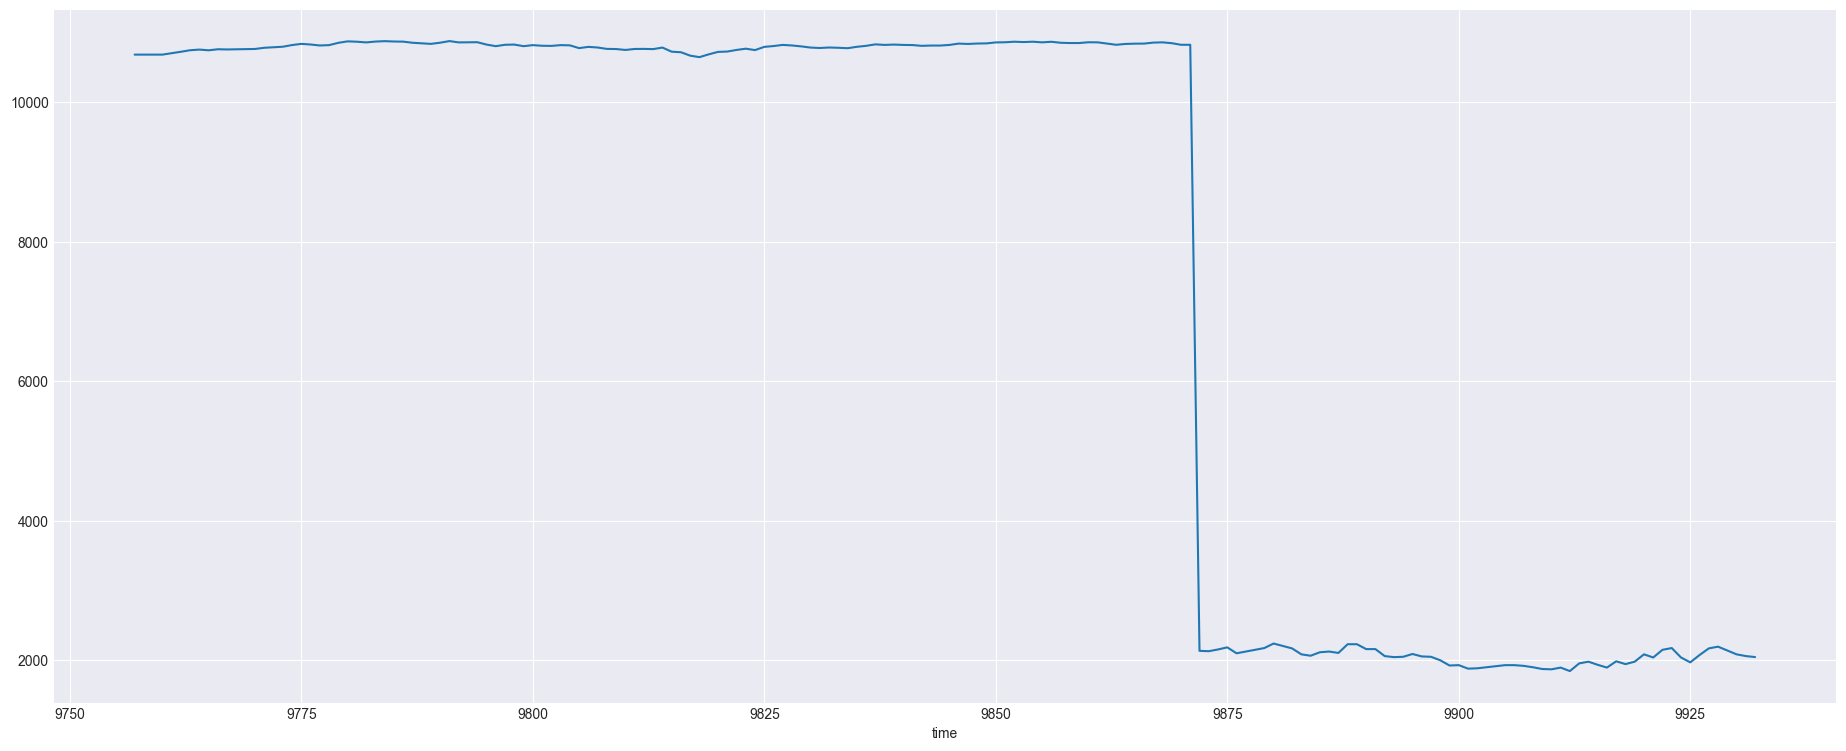

In [38]:
df_dataset[df_dataset["id"] == "D4047"].set_index("time")["value"].plot()

<Axes: xlabel='time'>

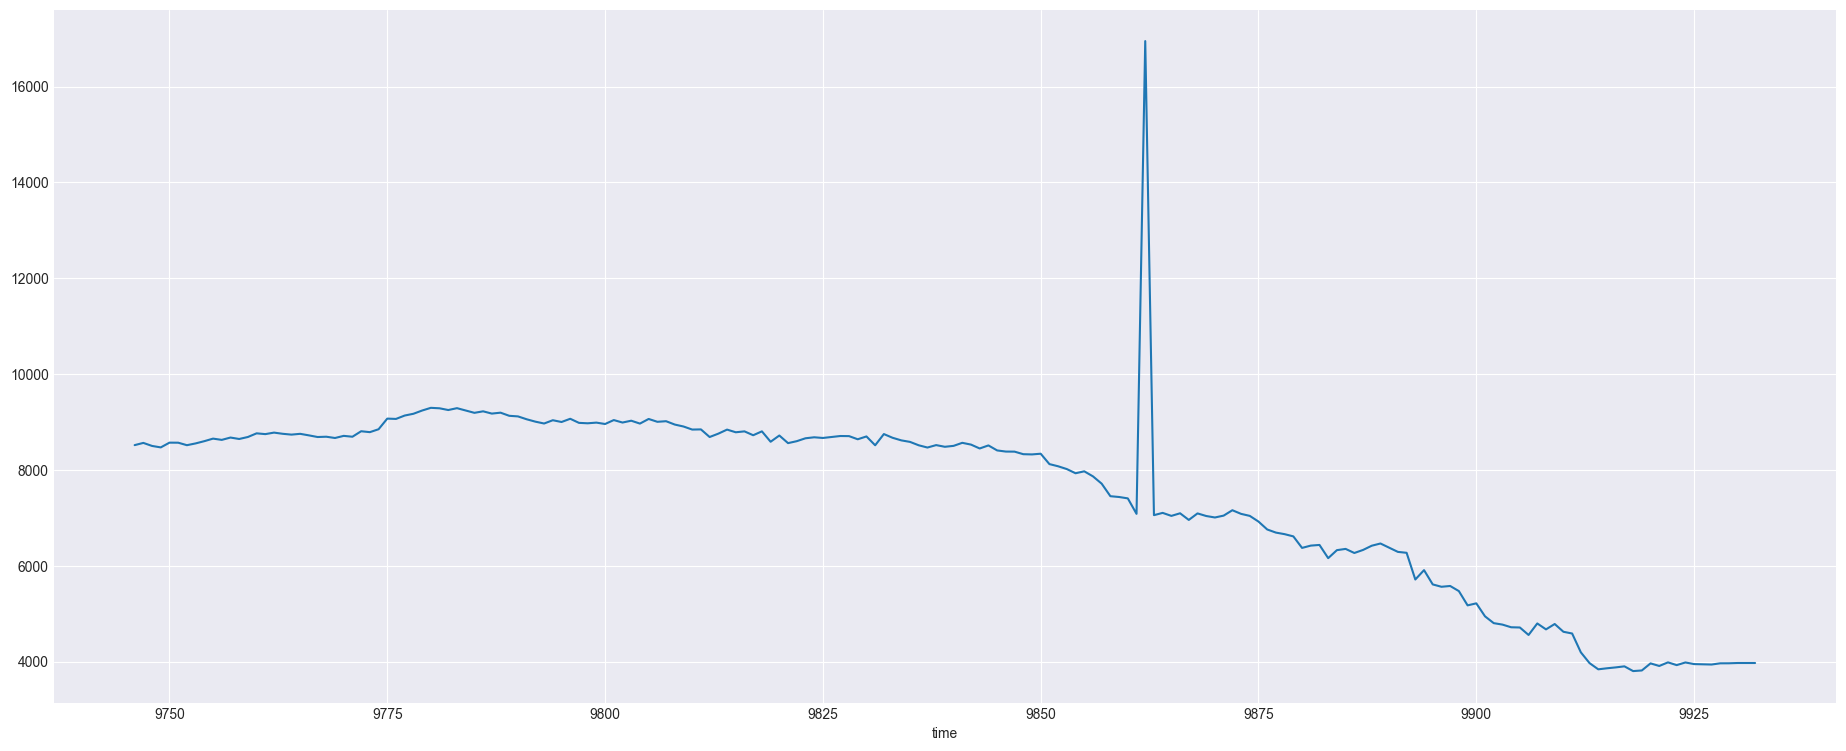

In [39]:
df_dataset[df_dataset["id"] == "D1992"].set_index("time")["value"].plot()

## 2. Симметричность

In [40]:
dataset_features.sort_values("value__symmetry_looking__r_0.5")

,"value__agg_linear_trend__attr_""slope""__chunk_len_30__f_agg_""mean""","value__linear_trend__attr_""slope""",value__c3__lag_1,value__cid_ce__normalize_True,value__lempel_ziv_complexity__bins_10,value__permutation_entropy__dimension_7__tau_3,value__symmetry_looking__r_0.5,value__time_reversal_asymmetry_statistic__lag_7,value__variation_coefficient
D1,32.317861,1.077230,3.380948e+09,0.727822,0.146078,5.535030,1.0,7.147901e+07,0.224711
D3527,87.942420,2.925189,1.160540e+12,2.159695,0.094039,6.372808,1.0,9.114489e+09,0.475943
D3528,81.782349,2.712066,6.958738e+11,2.170711,0.090002,6.353427,1.0,7.926391e+09,0.491928
D3529,64.980548,2.159794,7.175084e+11,2.739542,0.101639,6.355564,1.0,5.345022e+09,0.395819
D353,3.814432,-0.374126,3.253132e+11,2.596428,0.232945,5.130450,1.0,1.910632e+09,0.063809
...,...,...,...,...,...,...,...,...,...
D2272,10.834662,0.378326,3.907883e+10,3.435089,0.094299,6.527863,1.0,2.439049e+07,0.420892
D2273,73.193577,2.429013,6.634166e+11,2.085107,0.091924,6.655317,1.0,5.999484e+09,0.453079
D2274,3.111215,0.103757,4.192118e+09,5.099302,0.141254,6.399094,1.0,1.301548e+07,0.258876
D2261,1.435347,0.046068,2.206247e+09,3.024905,0.098337,6.519677,1.0,6.154564e+06,0.306853


<Axes: xlabel='time'>

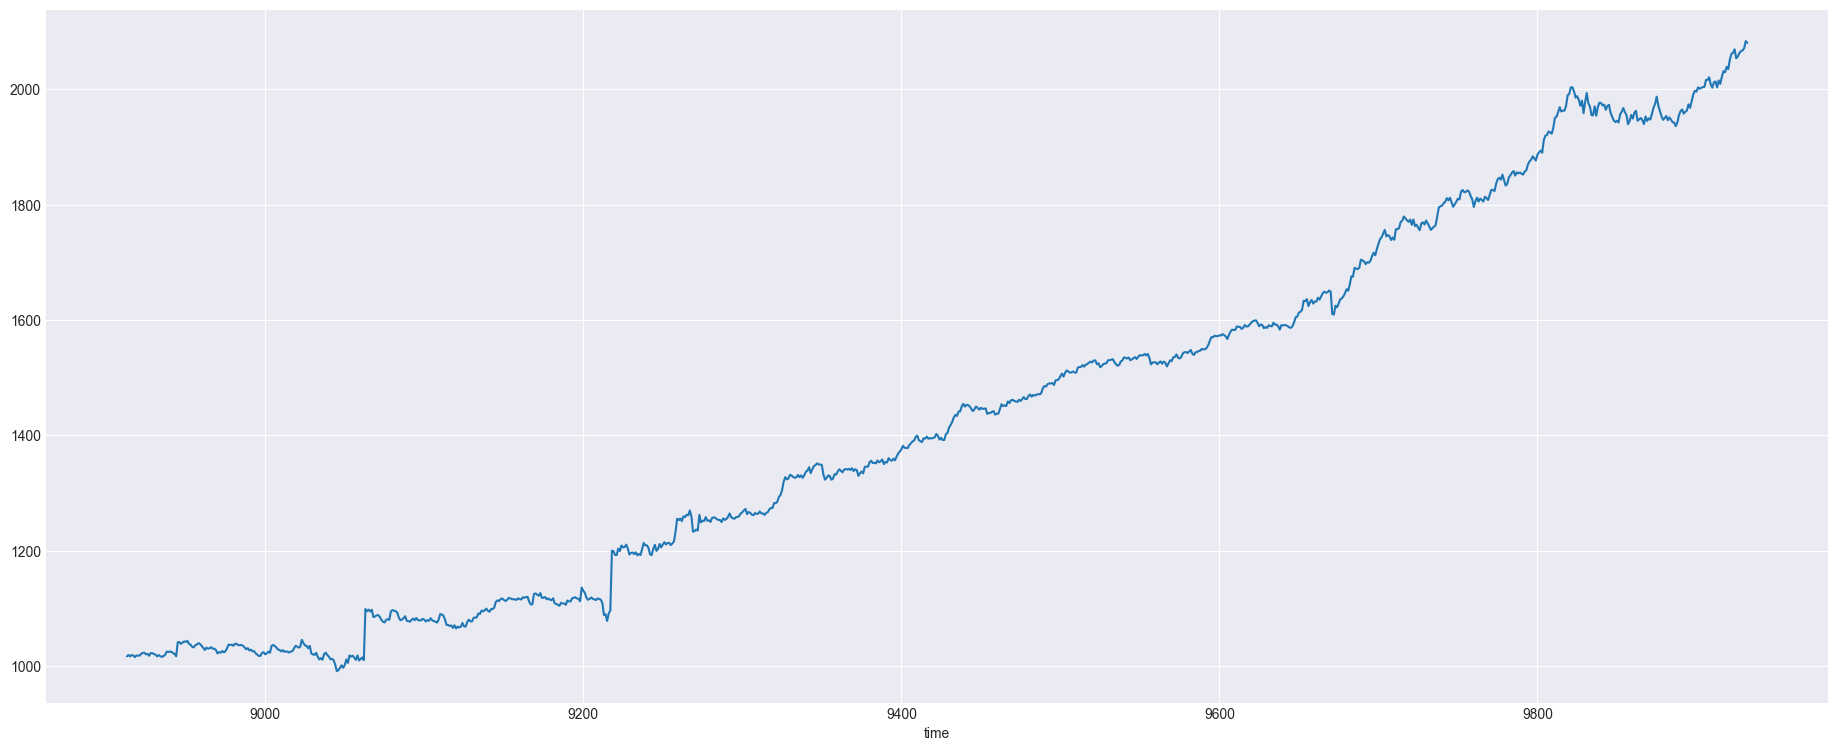

In [41]:
df_dataset[df_dataset["id"] == "D1"].set_index("time")["value"].plot()

<Axes: >

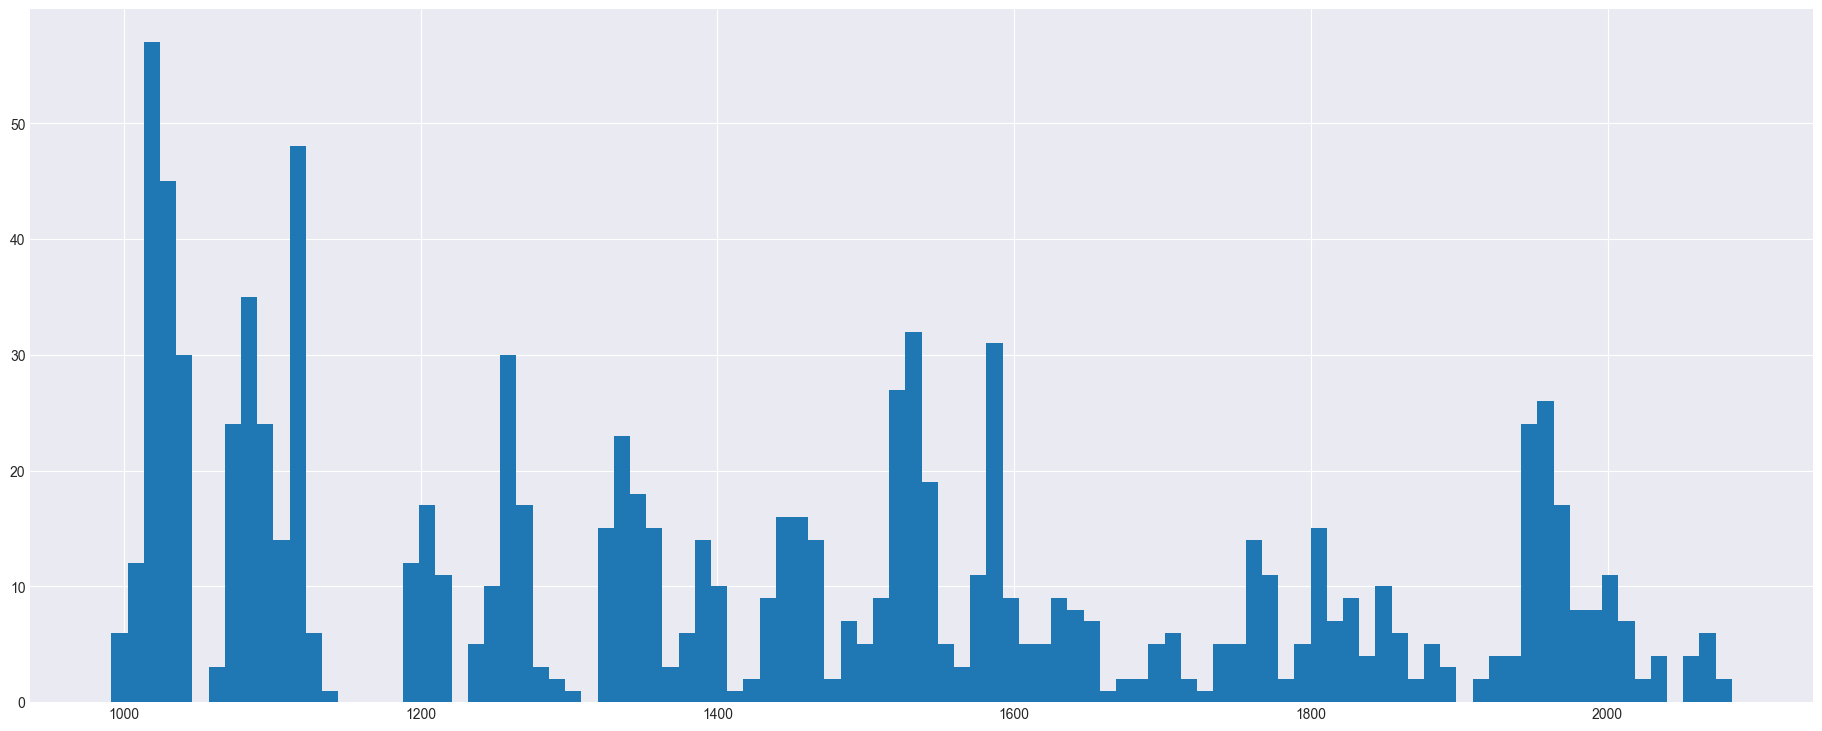

In [42]:
df_dataset[df_dataset["id"] == "D1"]["value"].hist(bins=100)

<Axes: xlabel='time'>

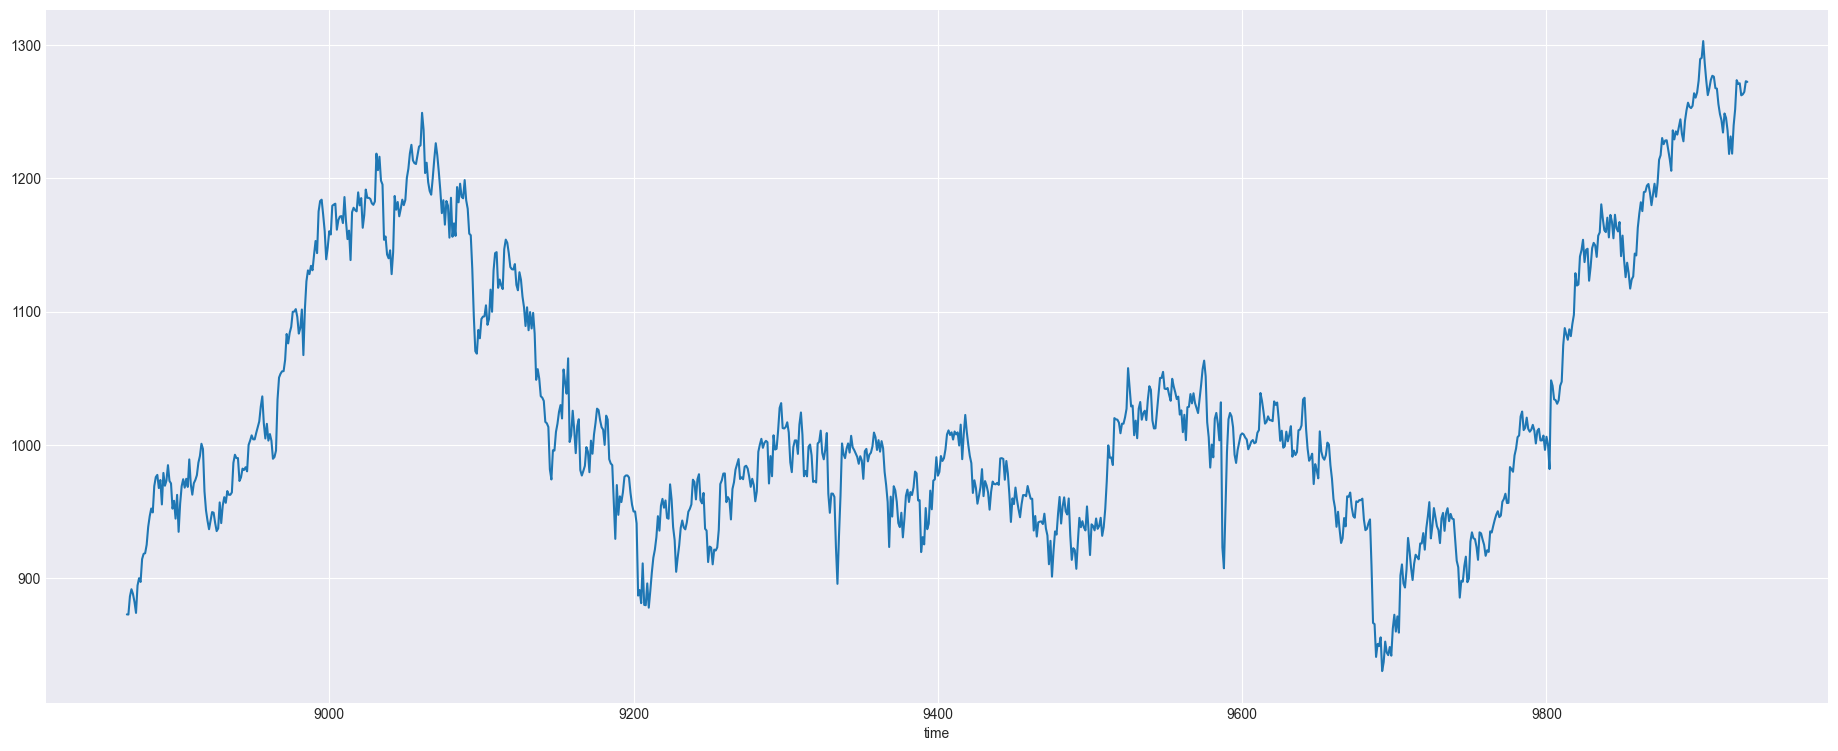

In [43]:
df_dataset[df_dataset["id"] == "D999"].set_index("time")["value"].plot()

<Axes: >

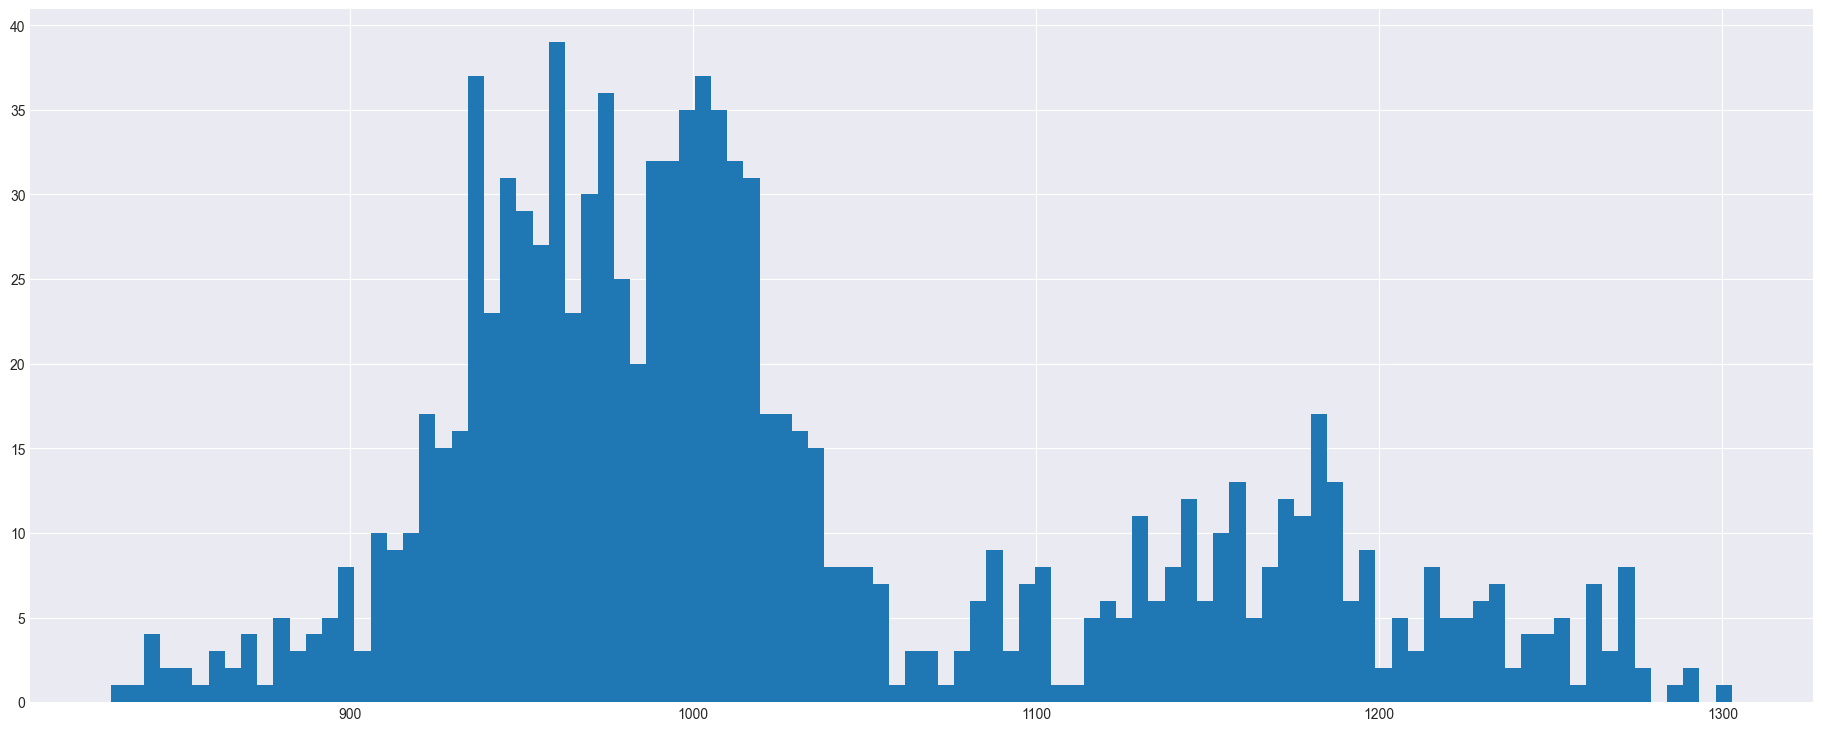

In [44]:
df_dataset[df_dataset["id"] == "D999"]["value"].hist(bins=100)

## 3. Предсказуемость

In [45]:
dataset_features.sort_values("value__cid_ce__normalize_True")

,"value__agg_linear_trend__attr_""slope""__chunk_len_30__f_agg_""mean""","value__linear_trend__attr_""slope""",value__c3__lag_1,value__cid_ce__normalize_True,value__lempel_ziv_complexity__bins_10,value__permutation_entropy__dimension_7__tau_3,value__symmetry_looking__r_0.5,value__time_reversal_asymmetry_statistic__lag_7,value__variation_coefficient
D2140,-1031.979000,-25.580150,5.622762e+10,0.716732,0.355372,2.002019,1.0,-2.906319e+09,0.403873
D1,32.317861,1.077230,3.380948e+09,0.727822,0.146078,5.535030,1.0,7.147901e+07,0.224711
D14,93.660171,3.123105,3.604472e+10,0.748990,0.131373,5.310389,1.0,1.854028e+09,0.335886
D2207,285.561667,13.024569,1.255111e+10,0.753729,0.302222,2.418194,1.0,6.069142e+07,0.640917
D2208,2351.966291,89.182627,1.613604e+12,0.807188,0.316583,2.800224,1.0,3.224031e+10,0.732778
...,...,...,...,...,...,...,...,...,...
D4212,-93.773443,-3.383380,2.284523e+10,19.143428,0.072000,4.652903,1.0,-1.130421e+10,0.615382
D4215,-97.873626,-3.502437,2.036102e+10,19.197273,0.072000,4.612075,1.0,-1.360092e+10,0.712606
D4213,-73.441209,-2.714452,1.213277e+10,19.209064,0.072000,4.706494,1.0,-9.462961e+09,0.762953
D4214,-50.287912,-1.863983,1.120783e+10,19.416218,0.072000,4.638870,1.0,-7.391289e+09,0.742569


<Axes: xlabel='time'>

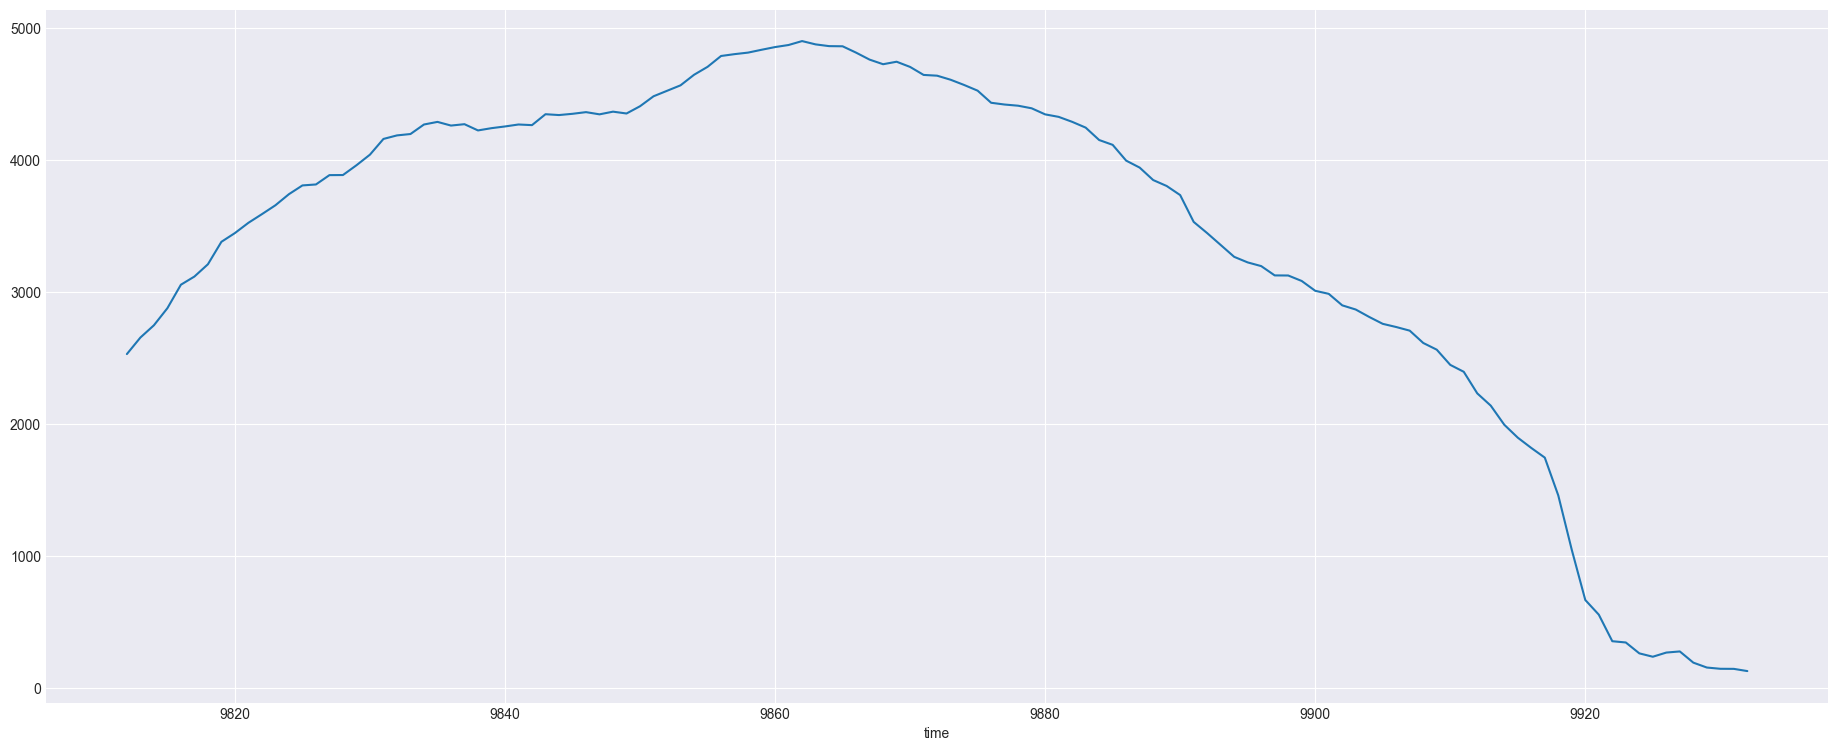

In [46]:
df_dataset[df_dataset["id"] == "D2140"].set_index("time")["value"].plot()

<Axes: xlabel='time'>

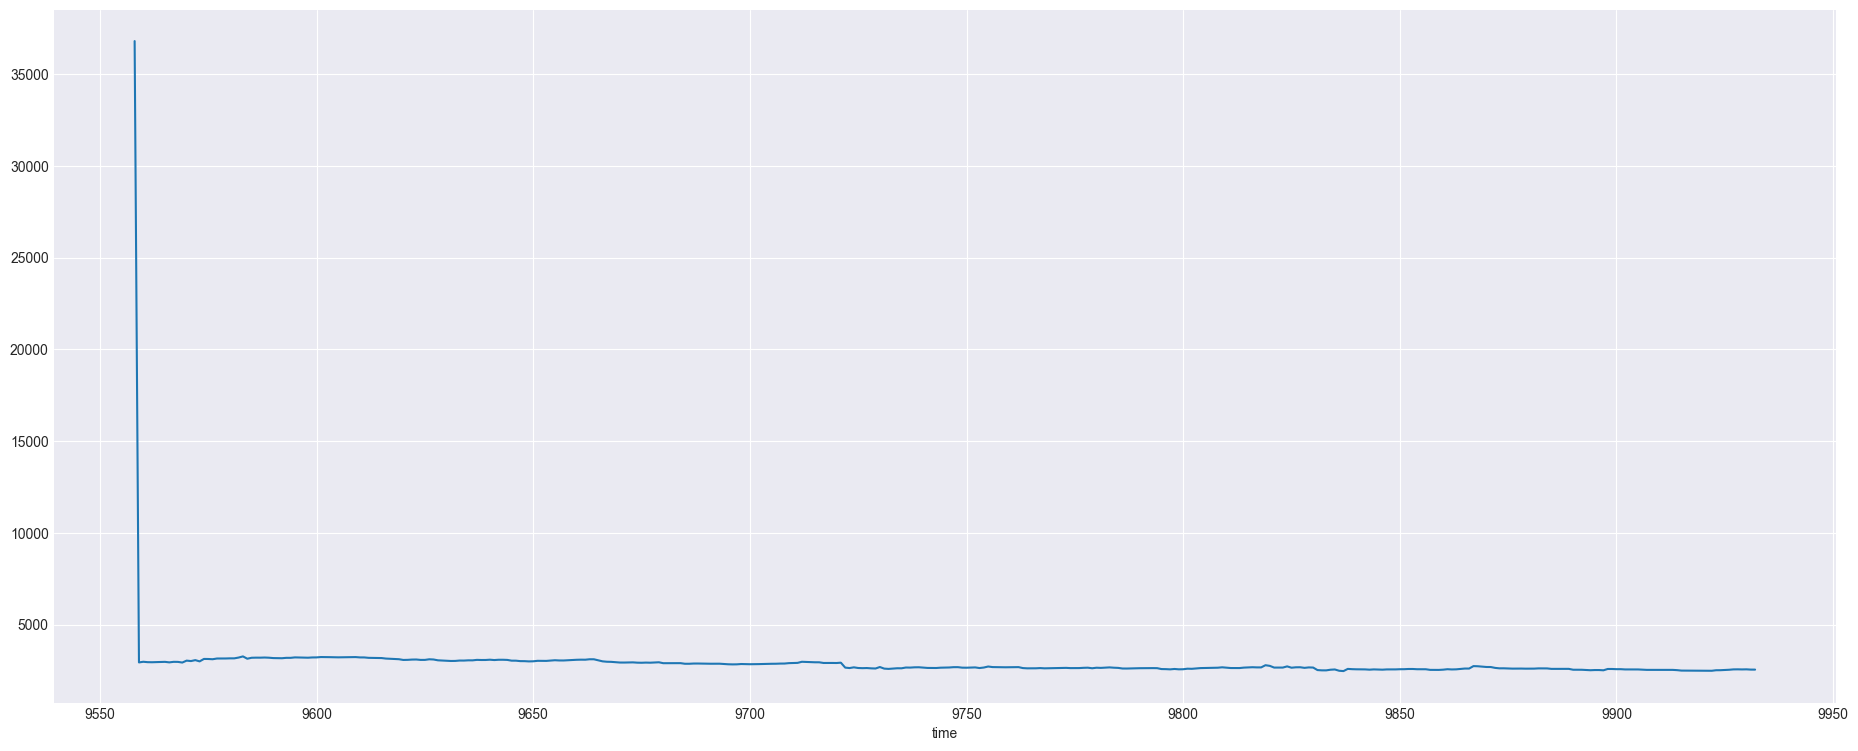

In [47]:
df_dataset[df_dataset["id"] == "D4212"].set_index("time")["value"].plot()

In [48]:
dataset_features.sort_values("value__lempel_ziv_complexity__bins_10")

,"value__agg_linear_trend__attr_""slope""__chunk_len_30__f_agg_""mean""","value__linear_trend__attr_""slope""",value__c3__lag_1,value__cid_ce__normalize_True,value__lempel_ziv_complexity__bins_10,value__permutation_entropy__dimension_7__tau_3,value__symmetry_looking__r_0.5,value__time_reversal_asymmetry_statistic__lag_7,value__variation_coefficient
D2194,21.467868,0.701476,1.528298e+12,5.829304,0.019476,6.524348,1.0,6.610183e+10,2.910008
D4099,-0.156435,-0.005214,1.151213e+09,10.661019,0.047619,6.698637,1.0,-1.907454e+05,0.026753
D1707,122.965241,3.252831,2.373932e+11,5.030864,0.050376,5.450039,1.0,2.851859e+10,1.722734
D70,18.988273,0.635493,5.767355e+09,4.734729,0.051961,5.538674,1.0,5.325401e+08,0.340306
D2016,33.052956,1.062067,7.164137e+10,1.748039,0.054782,6.596201,1.0,4.292697e+09,1.104034
...,...,...,...,...,...,...,...,...,...
D2188,-10.727667,-0.542791,3.159178e+09,4.244360,0.448000,3.688879,1.0,-3.416582e+06,0.028930
D1893,45.682058,1.613306,4.972538e+09,3.988411,0.451327,3.545011,1.0,1.981734e+08,0.054142
D2187,-10.341667,-0.551708,3.162676e+09,4.166027,0.456000,3.654222,1.0,-1.137850e+06,0.029284
D4085,-7.883860,-0.087425,1.340602e+10,7.507781,0.467890,3.515740,1.0,-4.602092e+07,0.020922


<Axes: xlabel='time'>

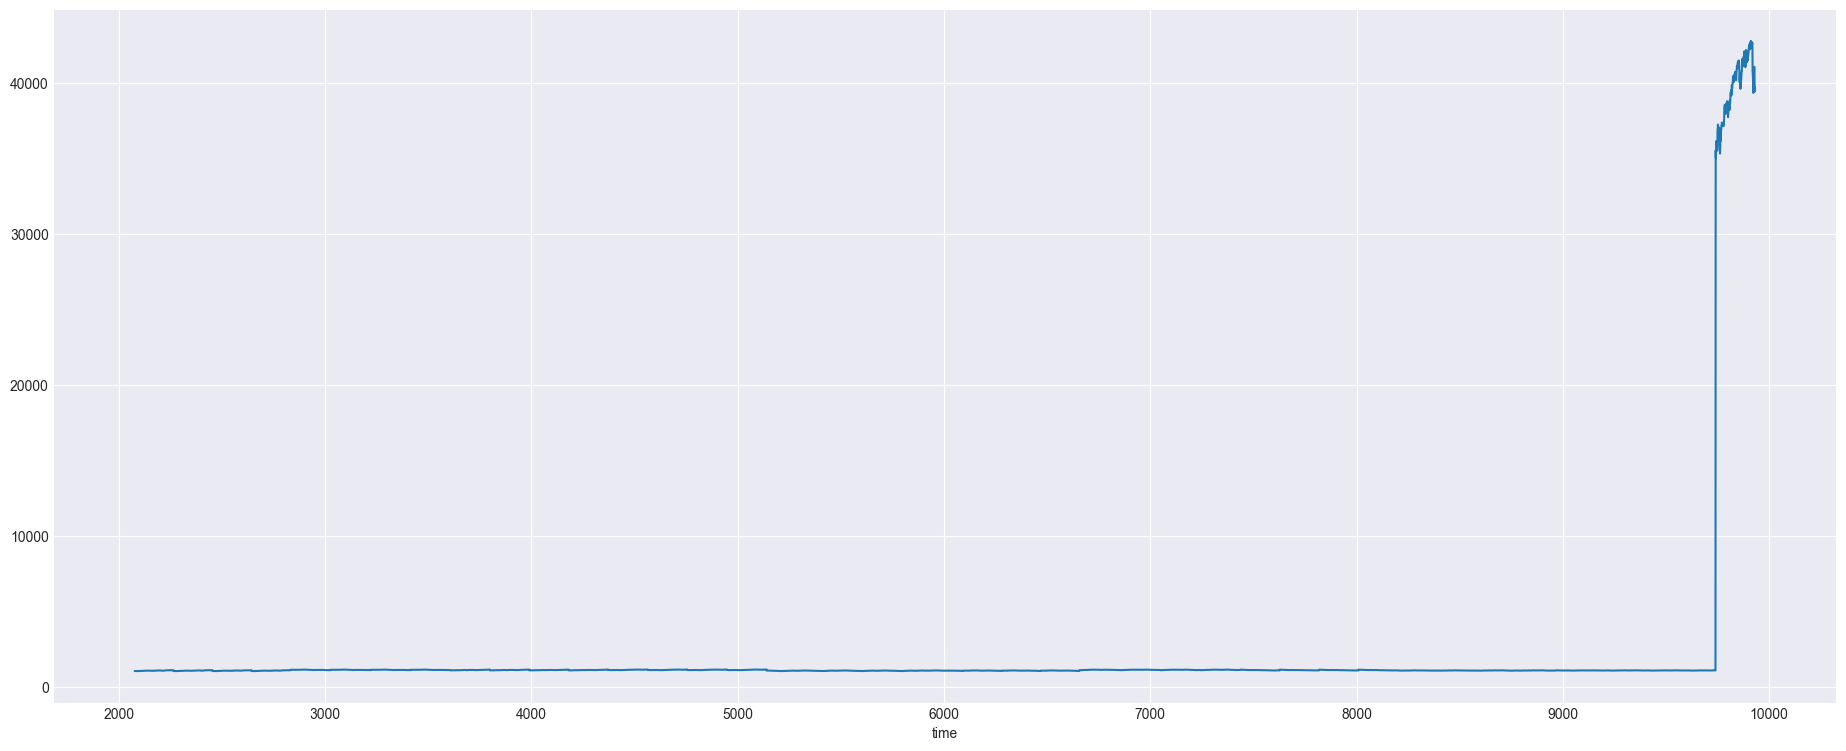

In [49]:
df_dataset[df_dataset["id"] == "D2194"].set_index("time")["value"].plot()

<Axes: xlabel='time'>

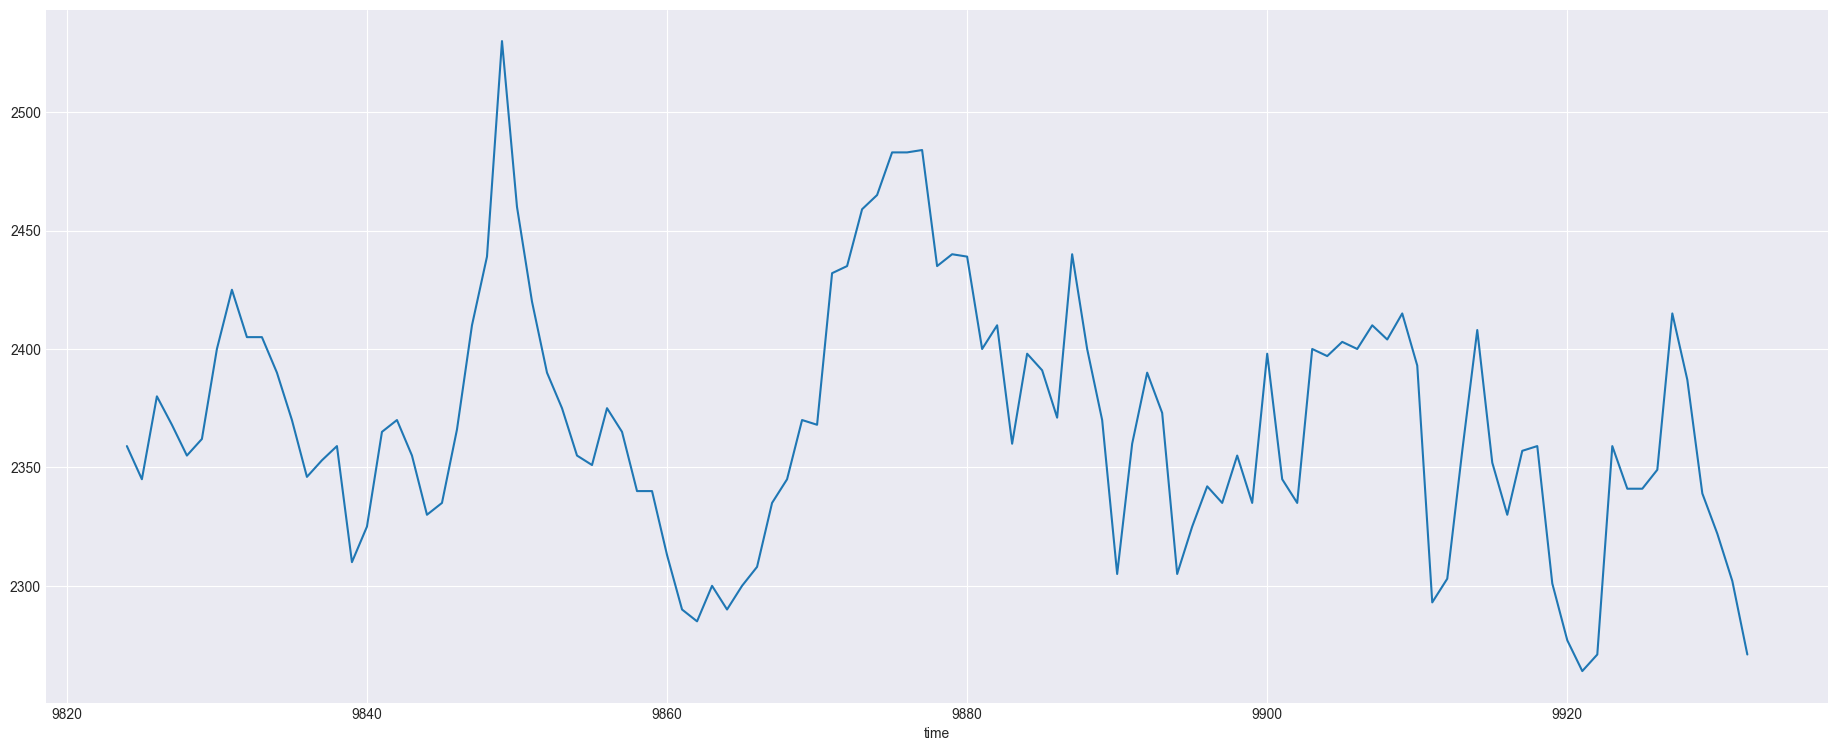

In [50]:
df_dataset[df_dataset["id"] == "D4086"].set_index("time")["value"].plot()